In [2]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [20]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Flatten, Dense
from tensorflow.keras.datasets import fashion_mnist
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
'''LRFinder class'''

class LRFind(tf.keras.callbacks.Callback): 
    def __init__(self, min_lr, max_lr, n_rounds): 
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.step_up = (max_lr / min_lr) ** (1 / n_rounds)
        self.lrs = []
        self.losses = []
     
    def on_train_begin(self, logs=None):
        self.weights = self.model.get_weights()
        self.model.optimizer.lr = self.min_lr

    def on_train_batch_end(self, batch, logs=None):
        self.lrs.append(self.model.optimizer.lr.numpy())
        self.losses.append(logs["loss"])
        self.model.optimizer.lr = self.model.optimizer.lr * self.step_up
        if self.model.optimizer.lr > self.max_lr:
            self.model.stop_training = True
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.weights)


In [12]:

# 1. Load data and define Data Generators
DATA_PATH = '/projects/shart/digital_pathology/data/dogs_vs_cats/images/'

train_datagen = ImageDataGenerator(
                rescale = 1. / 255,
                 shear_range = 0.2,
                  zoom_range = 0.2,
            horizontal_flip = True)
  
test_datagen = ImageDataGenerator(rescale = 1. / 255)
train_gen = train_datagen.flow_from_directory(DATA_PATH+'/train', target_size=(224, 224), batch_size = 64, class_mode ='binary')
valid_gen = test_datagen.flow_from_directory(DATA_PATH+'/val', target_size=(224, 224), batch_size = 64, class_mode ='binary')

Found 19000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


In [26]:

# 2. Initialize base model
base_model = DenseNet201(include_top=False, input_shape=(224,224,3))

        
# 3. Freeze layers from the base model
base_model.trainable = False
#for layer in base_model.layers:
#    layer.trainable=False

                        
# 4. Add Fully connected layer
model = Sequential([base_model,
                    GlobalAveragePooling2D(name='avg_pool'), Flatten(),
                    Dense(1024, activation='relu'),
                    Dense(1, activation='sigmoid')])


model.compile(loss='binary_crossentropy', \
              metrics=['accuracy'], optimizer='adam')


# 3. Fit using Callback
EPOCHS=1
lr_finder_steps = 250
lr_find = LRFind(1e-6, 1e1, lr_finder_steps)


#print(lr_find.lrs, lr_find.losses)

In [27]:
model.fit(train_gen,   callbacks=[lr_find], epochs=1)

297/297 [==============================] - 382s 1s/step - loss: 28.8583 - accuracy: 0.7665


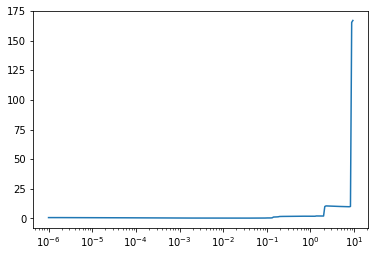

In [28]:

plt.plot(lr_find.lrs, lr_find.losses)
plt.xscale('log')
plt.show()